# [슬기로운 통계생활](https://www.youtube.com/c/statisticsplaybook) at DACON!

안녕하세요~! R 사용자들의 데이터 경진대회 참여율을 높이기 위해서 baseline 코드 공개합니다. 요즘 핫한 Tidymodels를 사용해서 월간 데이콘 14 - 신용카드 사용자 연체 예측 AI 경진대회 베이스라인을 잡아보도록 합시다.

[슬통 캐글 R 스터디](https://www.youtube.com/playlist?list=PLKtLBdGREmMlJCXjCpCi5B4KQ-TsFvAAi)에도 많은 관심 부탁드립니다! R유저 화이팅~! 😎

# 준비작업

## 패키지 불러오기

이번 포스팅에서 사용할 R패키지들을 불러오자. 특히 요즘 핫하디 핫한 `tidymodels` 사용하여 월마트 대회를 가지고 놀아본다. 또한 마이 빼이보릿 연산자들을 사용하기 위하여 `magrittr`를 불러왔다.


In [1]:
suppressMessages(library(magrittr))
suppressMessages(library(tidymodels)) %>% suppressWarnings()
suppressMessages(library(tidyverse)) %>% suppressWarnings()
suppressMessages(library(skimr)) %>% suppressWarnings()
suppressMessages(library(knitr)) %>% suppressWarnings()
theme_set(theme_bw())


## 데이터셋 불러오기

이 대회에서 주어진 데이터셋을 불러보자. 주어진 파일 리스트는 다음과 같다.


In [2]:
file_path <- "../input/daconcredit14/"
files <- list.files(file_path)
files


[1] "sample_submission.csv" "test.csv"              "train.csv"

각 변수의 이름을 `janitor` 패키지로 말끔하게 바꿔준다.



In [3]:
train <- read_csv(file.path(file_path, "train.csv"),
                  col_types = cols(
                    credit = col_factor(levels = c("0.0", "1.0", "2.0"))
                  )) %T>% 
  suppressMessages() %>% 
  janitor::clean_names()
test <- read_csv(file.path(file_path, "test.csv")) %T>%
  suppressMessages() %>% 
  janitor::clean_names()


# 데이터 기본정보 확인



In [28]:
train %>% 
  head()

index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,days_birth,days_employed,flag_mobil,work_phone,phone,email,occyp_type,family_size,begin_month,credit
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
0,F,N,N,0,202500,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NA,2,-6,1.0
1,F,N,Y,1,247500,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3,-5,1.0
2,M,Y,Y,0,450000,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2,-22,2.0
3,F,N,Y,0,202500,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2,-37,0.0
4,F,Y,Y,0,157500,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2,-26,2.0
5,F,N,Y,2,270000,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,1,0,0,1,High skill tech staff,4,-18,1.0


## 기본 정보

이 대회는 기본적으로 간단한 대회이다. 첫번째 스터디용 대회로 선택을 한 이유이기도 하다. 주 데이터는 2만 6천개의 train 표본과 1만개의 test 표본들로 구성이 되어있다.


In [5]:
dim(train)



[1] 26457    20

In [6]:
dim(test)



[1] 10000    19

각 데이터 셋의 변수명을 살펴보자. 



In [7]:
names(train)



[1] "index"         "gender"        "car"           "reality"      
 [5] "child_num"     "income_total"  "income_type"   "edu_type"     
 [9] "family_type"   "house_type"    "days_birth"    "days_employed"
[13] "flag_mobil"    "work_phone"    "phone"         "email"        
[17] "occyp_type"    "family_size"   "begin_month"   "credit"

In [8]:
names(test)



[1] "index"         "gender"        "car"           "reality"      
 [5] "child_num"     "income_total"  "income_type"   "edu_type"     
 [9] "family_type"   "house_type"    "days_birth"    "days_employed"
[13] "flag_mobil"    "work_phone"    "phone"         "email"        
[17] "occyp_type"    "family_size"   "begin_month"

먼저 `test` 데이터에는 우리가 예측하고 싶은 변수인 `credit` 변수가 들어있지 않은 것을 알 수 있다. 

데이터를 훑어보기 위해서 `skim()` 함수를 이용하자. 이 함수는 데이터에 들어있는 변수들을 타입 별로 분석해서 리포트를 작성해준다.


In [9]:
skim(train)



── Data Summary ────────────────────────
                           Values
Name                       train 
Number of rows             26457 
Number of columns          20    
_______________________          
Column type frequency:           
  character                8     
  factor                   1     
  numeric                  11    
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 gender                0         1         1     1     0        2          0
2 car                   0         1         1     1     0        2          0
3 reality               0         1         1     1     0        2          0
4 income_type           0         1         7    20     0        5          0
5 edu_type              0         1        15    29     0        5          0
6 family_type           0         1

결과를 살펴보자. 먼저 결측치가 상대적으로 많이 없는 착한? 데이터이다. character 변수의 complete rate를 살펴보면 모든 변수가 1이고, `occyp_type` 변수만이 결측치가 8171개가 존재하는 것을 알 수 있다. 또한 고맙게도 numeric 변수의 결측치는 하나도 없다!😆

같은 함수를 사용해서 `test` 셋을 보면 똑같은 패턴을 가지고 있는 것을 알 수 있다.


In [10]:
skim(test)



── Data Summary ────────────────────────
                           Values
Name                       test  
Number of rows             10000 
Number of columns          19    
_______________________          
Column type frequency:           
  character                8     
  numeric                  11    
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 gender                0         1         1     1     0        2          0
2 car                   0         1         1     1     0        2          0
3 reality               0         1         1     1     0        2          0
4 income_type           0         1         7    20     0        5          0
5 edu_type              0         1        15    29     0        5          0
6 family_type           0         1         5    20     0        5   

# 시각화

베이스 라인을 잡은 문서이니 간단하게 시각화 하나만 하고 넘어가자. (코드를 응용해서 다른 변수에 대한 상관 관계를 볼 수 있을 것이다.)


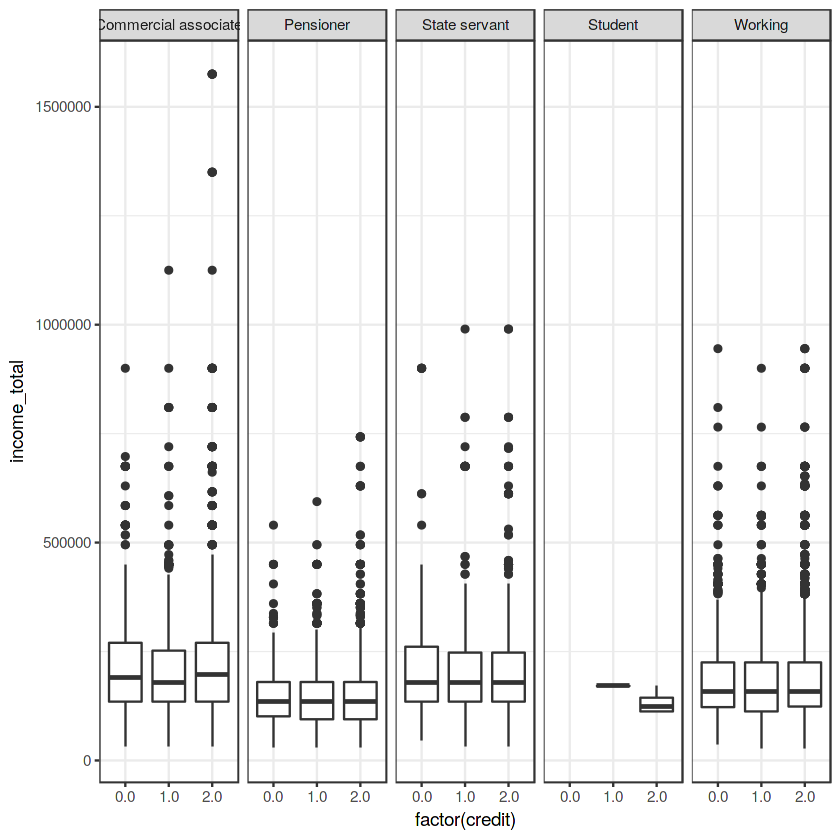

In [11]:
train %>%
  ggplot(aes(x = factor(credit), y = income_total)) +
  geom_boxplot() +
  facet_grid(. ~ income_type)


목표 변수인 credit은 낮을 수록 높은 신용의 신용카드 사용자를 의미 한다고 한다. Commercial associate 인 경우 신용이 제일 낮은 그룹의 수입의 중앙값이 제일 높다. 돈을 많이 벌수록 돈 갚은 개념이 없어지는 것인가? 재미있는 현상이다. 학생 클래스의 경우 train 데이터에 셋이 많이 없다는 것을 알 수 있다. 추후에 다른 클래스로 통합을 시키는 것이 좋을 것이다.

# 전처리 하기

`tidymodels`에서는 전처리를 할 때 `recipe` 라는 패키지를 사용한다. 이 패키지에는 전처리를 하는 방법을 음식 레피시 처럼 적어놓는다고 생각하면 쉽다.

## 전처리 사항들

* 결과값인 credit 변수와 character 타입의 변수들을 factor 변수로 바꿔주자.
* 나이와 직업을 가진 기간을 년수로 바꿔준다.

## `recipe`를 통한 전처리 입력


In [12]:
credit_recipe <- train %>% 
  recipe(credit ~ .) %>%
  # age and employment period in yrs
  step_mutate(yrs_birth = -ceiling(days_birth/365),
              yrs_employed = -ceiling(days_employed/356)) %>% 
  step_rm(index, days_birth, days_employed) %>%
  step_unknown(occyp_type) %>% 
  step_integer(all_nominal(), -all_outcomes()) %>% 
  step_center(all_predictors(), -all_outcomes()) %>% 
  prep(training = train)

print(credit_recipe)


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         19

Training data contained 26457 data points and 8171 incomplete rows. 

Operations:

Variable mutation for yrs_birth, yrs_employed [trained]
Variables removed index, days_birth, days_employed [trained]
Unknown factor level assignment for occyp_type [trained]
Integer encoding for gender, car, reality, income_type, edu_type, ... [trained]
Centering for gender, car, reality, child_num, ... [trained]


## `juice`를 통한 전처리 즙짜기

`juice()` 함수를 통해서 recipe에 입력된 전처리를 짜낸 데이터를 얻어온다.


In [13]:
train2 <- juice(credit_recipe)
test2 <- bake(credit_recipe, new_data = test)
head(train2)
head(test2)


gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,flag_mobil,work_phone,phone,email,occyp_type,family_size,begin_month,credit,yrs_birth,yrs_employed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
-0.3311033,-0.3797483,-0.6739237,-0.4286578,15193.48,-2.3947538,-2.0975923,-0.3672752,0.7201875,0,-0.224742,-0.294251,-0.09128019,7.1698605,-0.1968477,20.1232944,1.0,-5.213478,179.3512
-0.3311033,-0.3797483,0.3260763,0.5713422,60193.48,-2.3947538,0.9024077,-1.3672752,-0.2798125,0,-0.224742,-0.294251,0.90871981,-2.8301395,0.8031523,21.1232944,1.0,-12.213478,170.3512
0.6688967,0.6202517,0.3260763,-0.4286578,262693.48,1.6052462,-2.0975923,-0.3672752,-0.2798125,0,-0.224742,0.705749,-0.09128019,-0.8301395,-0.1968477,4.1232944,2.0,8.786522,178.3512
-0.3311033,-0.3797483,0.3260763,-0.4286578,15193.48,-2.3947538,0.9024077,-0.3672752,-0.2798125,0,-0.224742,0.705749,-0.09128019,3.1698605,-0.1968477,-10.8767056,0.0,-2.213478,171.3512
-0.3311033,0.6202517,0.3260763,-0.4286578,-29806.52,-0.3947538,-2.0975923,-0.3672752,-0.2798125,0,-0.224742,-0.294251,-0.09128019,-0.8301395,-0.1968477,0.1232944,2.0,-2.213478,171.3512
-0.3311033,-0.3797483,0.3260763,1.5713422,82693.48,1.6052462,0.9024077,-0.3672752,-0.2798125,0,-0.224742,-0.294251,0.90871981,-5.8301395,1.8031523,8.1232944,1.0,-7.213478,180.3512


gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,flag_mobil,work_phone,phone,email,occyp_type,family_size,begin_month,yrs_birth,yrs_employed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.6688967,0.6202517,-0.6739237,-0.4286578,-74806.52,-1.3947538,0.9024077,-1.3672752,-0.2798125,0,-0.224742,0.705749,-0.09128019,7.1698605,-0.1968477,-33.876706,16.7865215,-859.6488
-0.3311033,-0.3797483,0.3260763,-0.4286578,-52306.52,-0.3947538,-2.0975923,-0.3672752,-0.2798125,0,-0.224742,0.705749,-0.09128019,-7.8301395,-0.1968477,-9.876706,7.7865215,190.3512
-0.3311033,-0.3797483,0.3260763,-0.4286578,-117934.52,1.6052462,0.9024077,-0.3672752,-0.2798125,0,0.775258,0.705749,-0.09128019,-2.8301395,-0.1968477,-13.876706,-0.2134785,166.3512
0.6688967,0.6202517,-0.6739237,-0.4286578,-74806.52,-2.3947538,0.9024077,-0.3672752,-0.2798125,0,0.775258,-0.294251,-0.09128019,-6.8301395,-0.1968477,-14.876706,8.7865215,173.3512
-0.3311033,0.6202517,0.3260763,-0.4286578,37693.48,-0.3947538,-2.0975923,-0.3672752,-0.2798125,0,0.775258,-0.294251,-0.09128019,-0.8301395,-0.1968477,18.123294,4.7865215,192.3512
-0.3311033,0.6202517,0.3260763,-0.4286578,-61306.52,1.6052462,0.9024077,1.6327248,-0.2798125,0,-0.224742,-0.294251,-0.09128019,-7.8301395,-1.1968477,21.123294,6.7865215,171.3512


다음과 같이 결측치 없이 잘 코딩된 데이터를 얻었다는 것을 확인 할 수 있다.



In [14]:
train2 %>%
map_df(~sum(is.na(.))) %>%
  pivot_longer(cols = everything(),
       names_to = "variable",
       values_to = "na_count") %>% 
  filter(na_count > 0)


variable,na_count
<chr>,<int>


전처리가 끝났으므로, train과 test셋을 나눈다.

# 튜닝 준비하기

`validation_split()` 함수를 사용하여 평가셋을 분리한다. 한 단계 더 나아간 cross validation은 `vfold_cv()`함수에서 제공하니 찾아보도록 하자.


In [15]:
set.seed(2021)

validation_split <- validation_split(train2, prop = 0.7, 
                                     strata = credit)


## 튜닝 스펙 설정

랜덤 포레스트를 사용할 것이고, mtry와 min_n을 어떻게 정할지를 평가셋을 통해서 결정할 것이므로, `tune()`를 사용해서 tidymodels에게 알려주도록 한다.


In [16]:
cores <- parallel::detectCores() -1
cores

tune_spec <- rand_forest(mtry = tune(),
                         min_n = tune(),
                         trees = 1000) %>% 
    set_engine("ranger",
               num.threads = cores) %>% 
    set_mode("classification")

# param_grid <- grid_latin_hypercube(finalize(mtry(), x = train2[,-1]),
#                                    min_n(), size = 100)

# from param tune
param_grid <- tibble(mtry = 3, min_n = 5)


[1] 3

## 워크 플로우 설정



In [17]:
workflow <- workflow() %>%
  add_model(tune_spec) %>% 
  add_formula(credit ~ .)


# 모델 튜닝 with tune_grid()

# Tuning trees


In [18]:
library(tictoc)
tic()
tune_result <- workflow %>% 
  tune_grid(validation_split,
            grid = param_grid,
            metrics = metric_set(mn_log_loss))
toc()


16.13 sec elapsed


In [19]:
tune_result$.notes[[1]]$.notes
tune_result %>% 
  collect_metrics()


character(0)

mtry,min_n,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
3,5,mn_log_loss,multiclass,0.7229436,1,NA,Preprocessor1_Model1


# 튜닝결과 시각화



geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



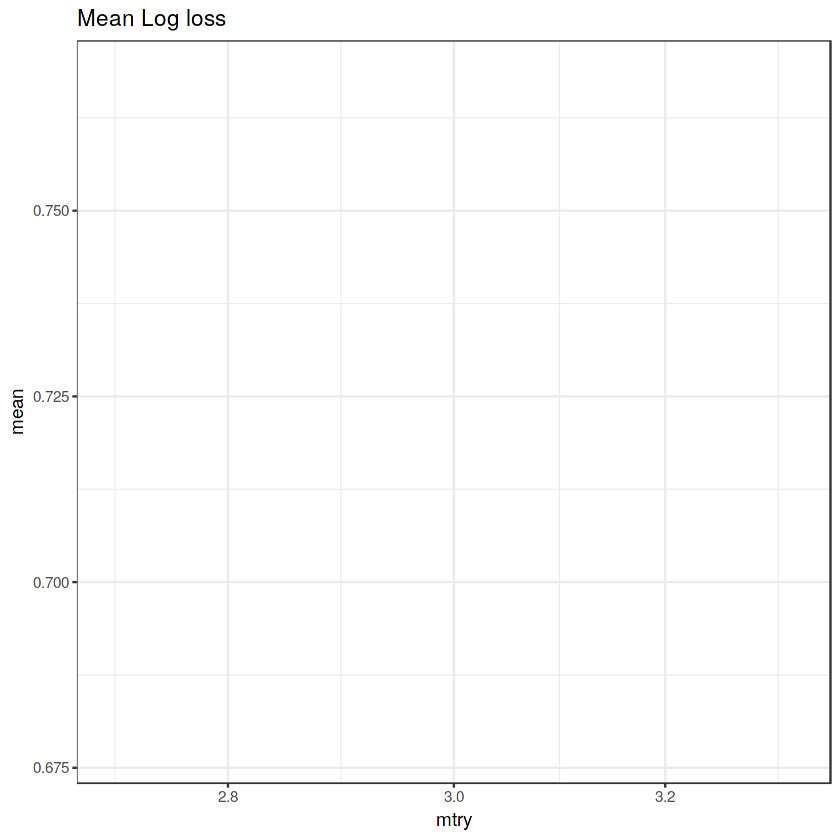

In [20]:
tune_result %>%
  collect_metrics() %>%
  filter(.metric == "mn_log_loss") %>% 
  ggplot(aes(mtry, mean, color = .metric)) +
  geom_line(size = 1.5) +
  scale_x_log10() +
  theme(legend.position = "none") +
  labs(title = "Mean Log loss")


In [21]:
tune_result %>% show_best()



mtry,min_n,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
3,5,mn_log_loss,multiclass,0.7229436,1,NA,Preprocessor1_Model1


In [22]:
tune_best <- tune_result %>% select_best(metric = "mn_log_loss")
tune_best$mtry
tune_best$min_n


[1] 3

[1] 5

# 튜닝된 모델 학습하기



In [23]:
rf_model <- 
  rand_forest(mtry = tune_best$mtry,
              min_n = tune_best$min_n,
              trees = 1000) %>% 
    set_engine("ranger", seed = 2021, 
               num.threads = cores) %>% 
    set_mode("classification")

tictoc::tic()
rf_fit <- 
    rf_model %>% 
    fit(credit ~ ., data = train2)
tictoc::toc()

options(max.print = 10)
rf_fit
# Ranger result
# 
# Type:                             Probability estimation 
# Number of trees:                  1000 
# Sample size:                      26457 
# Number of independent variables:  18 
# Mtry:                             3 
# Target node size:                 5 
# Variable importance mode:         none 
# Splitrule:                        gini 
# OOB prediction error (Brier s.):  0.2308023 


18.342 sec elapsed


parsnip model object

Fit time:  17.7s 
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, mtry = min_cols(~tune_best$mtry,      x), num.trees = ~1000, min.node.size = min_rows(~tune_best$min_n,      x), seed = ~2021, num.threads = ~cores, verbose = FALSE,      probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  1000 
Sample size:                      26457 
Number of independent variables:  18 
Mtry:                             3 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.2307974 

# 예측하기



In [24]:
result <- predict(rf_fit, test2, type = "prob")
result %>% head()


.pred_0.0,.pred_1.0,.pred_2.0
<dbl>,<dbl>,<dbl>
0.08372631,0.18182474,0.7344490
0.27217194,0.24857315,0.4792549
0.07474376,0.10633155,0.8189247
0.08209921,0.08572561,0.8321752
0.08675691,0.19492301,0.7183201
0.04590748,0.10530398,0.8487885


In [25]:
submission <- read_csv(file.path(file_path, "sample_submission.csv"))
sub_col <- names(submission)
submission <- bind_cols(submission$index, result)
names(submission) <- sub_col
write.csv(submission, row.names = FALSE,
          "baseline_dacon_credit.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  index = col_double(),
  `0` = col_double(),
  `1` = col_double(),
  `2` = col_double()
)


New names:
* NA -> ...1

